In [1]:
%load_ext autoreload
%autoreload 2
from alphatoe import models, plot, interpretability, game
import pandas as pd
import torch
from pytorch_memlab import LineProfiler, MemReporter
from showmethetypes import SMTT
import einops
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import numpy as np
import tqdm
import random

In [2]:
autoenc = torch.load("./sparse_autoencoder_on_activations_07NOV2023.pt")
act_data = torch.load("./all_games_act_data.pt")

In [3]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(
        local_encoder.W_in.shape[1], dtype=torch.float32
    ).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = act_data[torch.randperm(len(act_data))][: 2**14].to("cuda")

        hidden = local_encoder.get_act_density(tokens)

        act_freq_scores += hidden
        total += tokens.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

In [4]:
freqs = get_freqs(local_encoder=autoenc)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:28<00:00,  1.16s/it]

Num dead tensor(0.3975, device='cuda:0')


In [5]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [6]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations


def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [7]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_52900/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [8]:
end_game_types = list(games["first win condition"].unique())
print(end_game_types)

['left column', 'top left -> bottom right', 'top row', 'middle column', 'bottom left -> top right', 'right column', 'middle row', 'bottom row', nan]


In [9]:
non_9_move_games = games[games["steps till end state"] != 9]

In [10]:
# game_types x game x moves
game_kinds = [
    [
        [10] + eval(move)
        for move in non_9_move_games[
            non_9_move_games["first win condition"] == game_type
        ]["moves played"]
    ]
    for game_type in end_game_types[:-1]
]

In [11]:
# 30 seconds
game_count = 1_000
all_activations = []
for games in game_kinds:
    kind_activations = []
    for _ in range(game_count):
        data = torch.tensor(random.choice(games))
        kind_activations.append(neuron_activations(data)[0][-1])
    all_activations.append(torch.stack(kind_activations))
all_activations = torch.cat(all_activations)
all_activations = all_activations.detach().cpu().T

<Figure size 1000x1000 with 0 Axes>

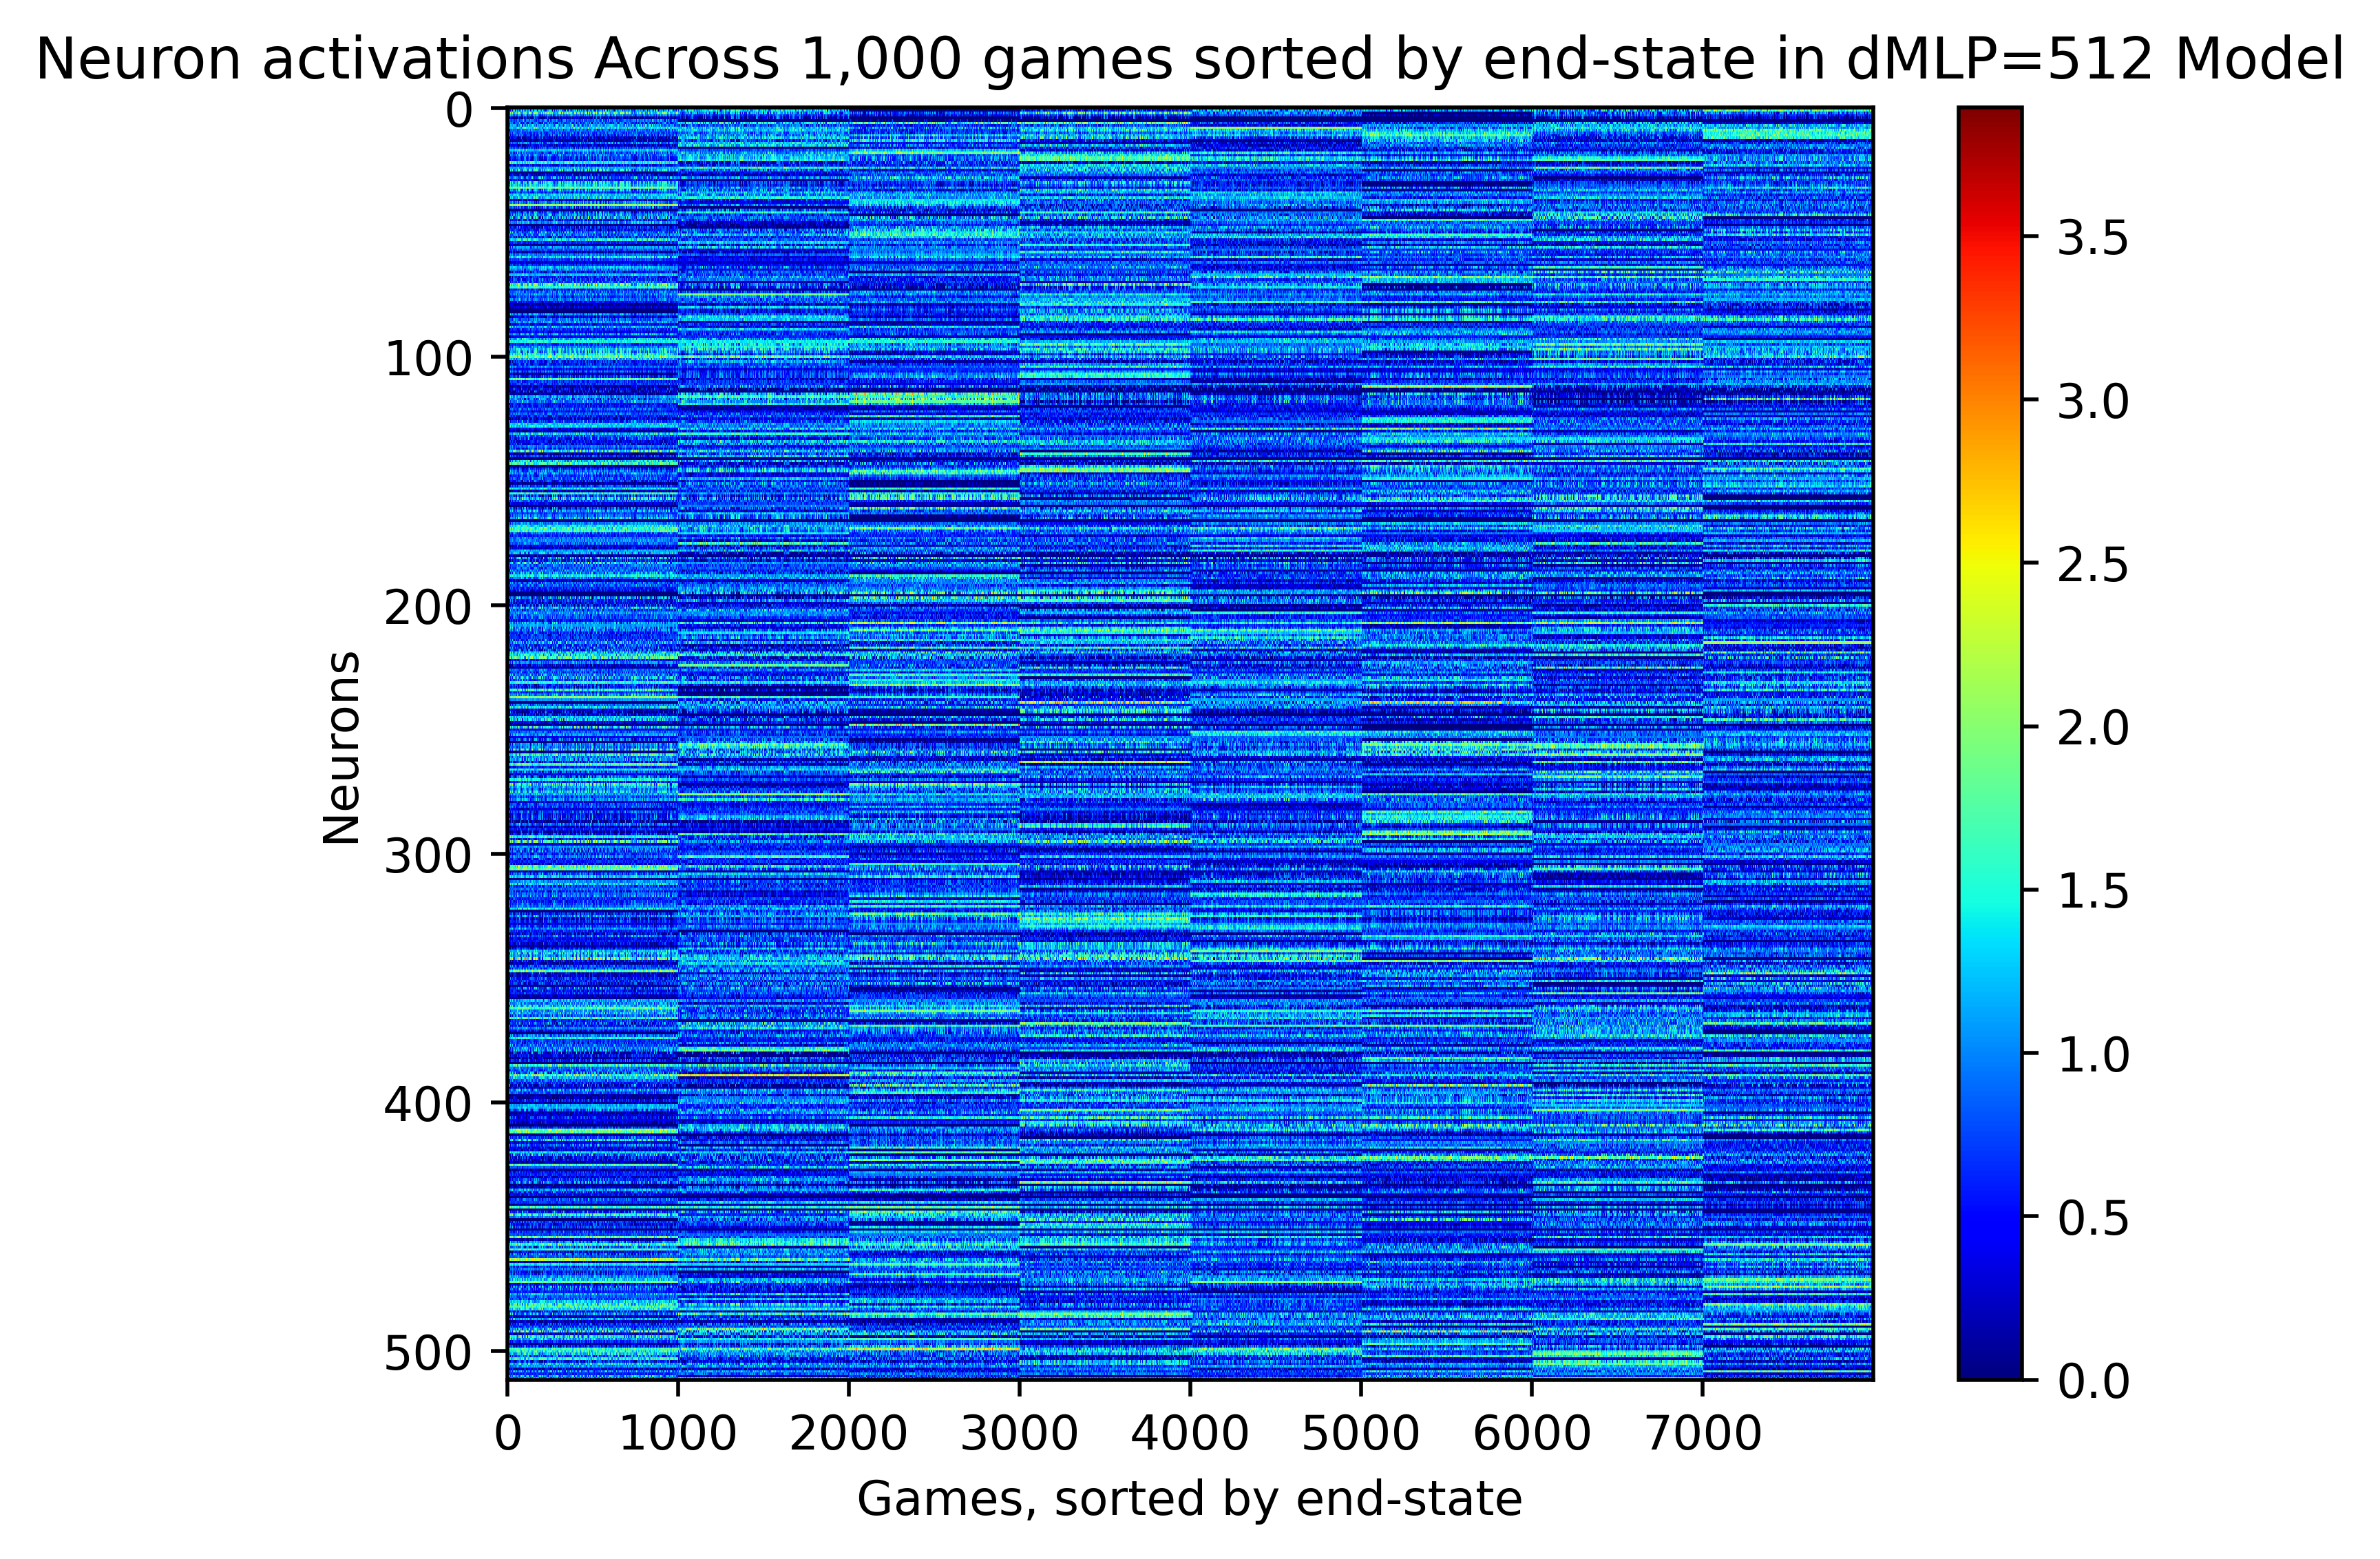

In [12]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_activations, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()

plt.xlabel("Games, sorted by end-state")

plt.ylabel("Neurons")
# title
plt.title(
    "Neuron activations Across 1,000 games sorted by end-state in dMLP=512 Model",
    fontsize=12,
)
plt.gcf().set_facecolor("white")

In [13]:
all_activations = all_activations.T

In [14]:
torch.save(
    autoenc.state_dict(), "./sparse_autoencoder_on_activations_07NOV2023_parameters.pt"
)

In [15]:
autoenc_cool = models.SparseAutoEncoder(512, 1024).cuda()

In [16]:
autoenc_cool.load_state_dict(
    torch.load("./sparse_autoencoder_on_activations_07NOV2023_parameters.pt")
)

<All keys matched successfully>

In [17]:
all_activations.to("cuda")

tensor([[1.0722, 1.2883, 2.0580,  ..., 0.3725, 0.8673, 0.8023],
        [1.0145, 1.3561, 1.1237,  ..., 0.4441, 1.3068, 1.1824],
        [1.0611, 0.6999, 2.0449,  ..., 0.5320, 0.9609, 0.9678],
        ...,
        [0.4567, 2.1772, 0.8640,  ..., 0.1647, 0.0893, 0.9271],
        [0.0000, 1.4919, 0.0000,  ..., 0.2910, 1.0475, 0.1759],
        [0.4963, 1.7205, 1.5188,  ..., 0.2614, 0.5633, 0.4557]],
       device='cuda:0')

In [18]:
all_features = torch.stack(
    [
        autoenc_cool.get_activations(activation.to("cuda"))
        for activation in tqdm.tqdm(all_activations)
    ]
)

100%|██████████| 8000/8000 [00:00<00:00, 31191.49it/s]


In [19]:
tt = SMTT("torch")

In [20]:
tt(all_features)

Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (8000)
    └── dim_1 (1024)


In [21]:
all_features = all_features.detach().cpu().T

<Figure size 1000x1000 with 0 Axes>

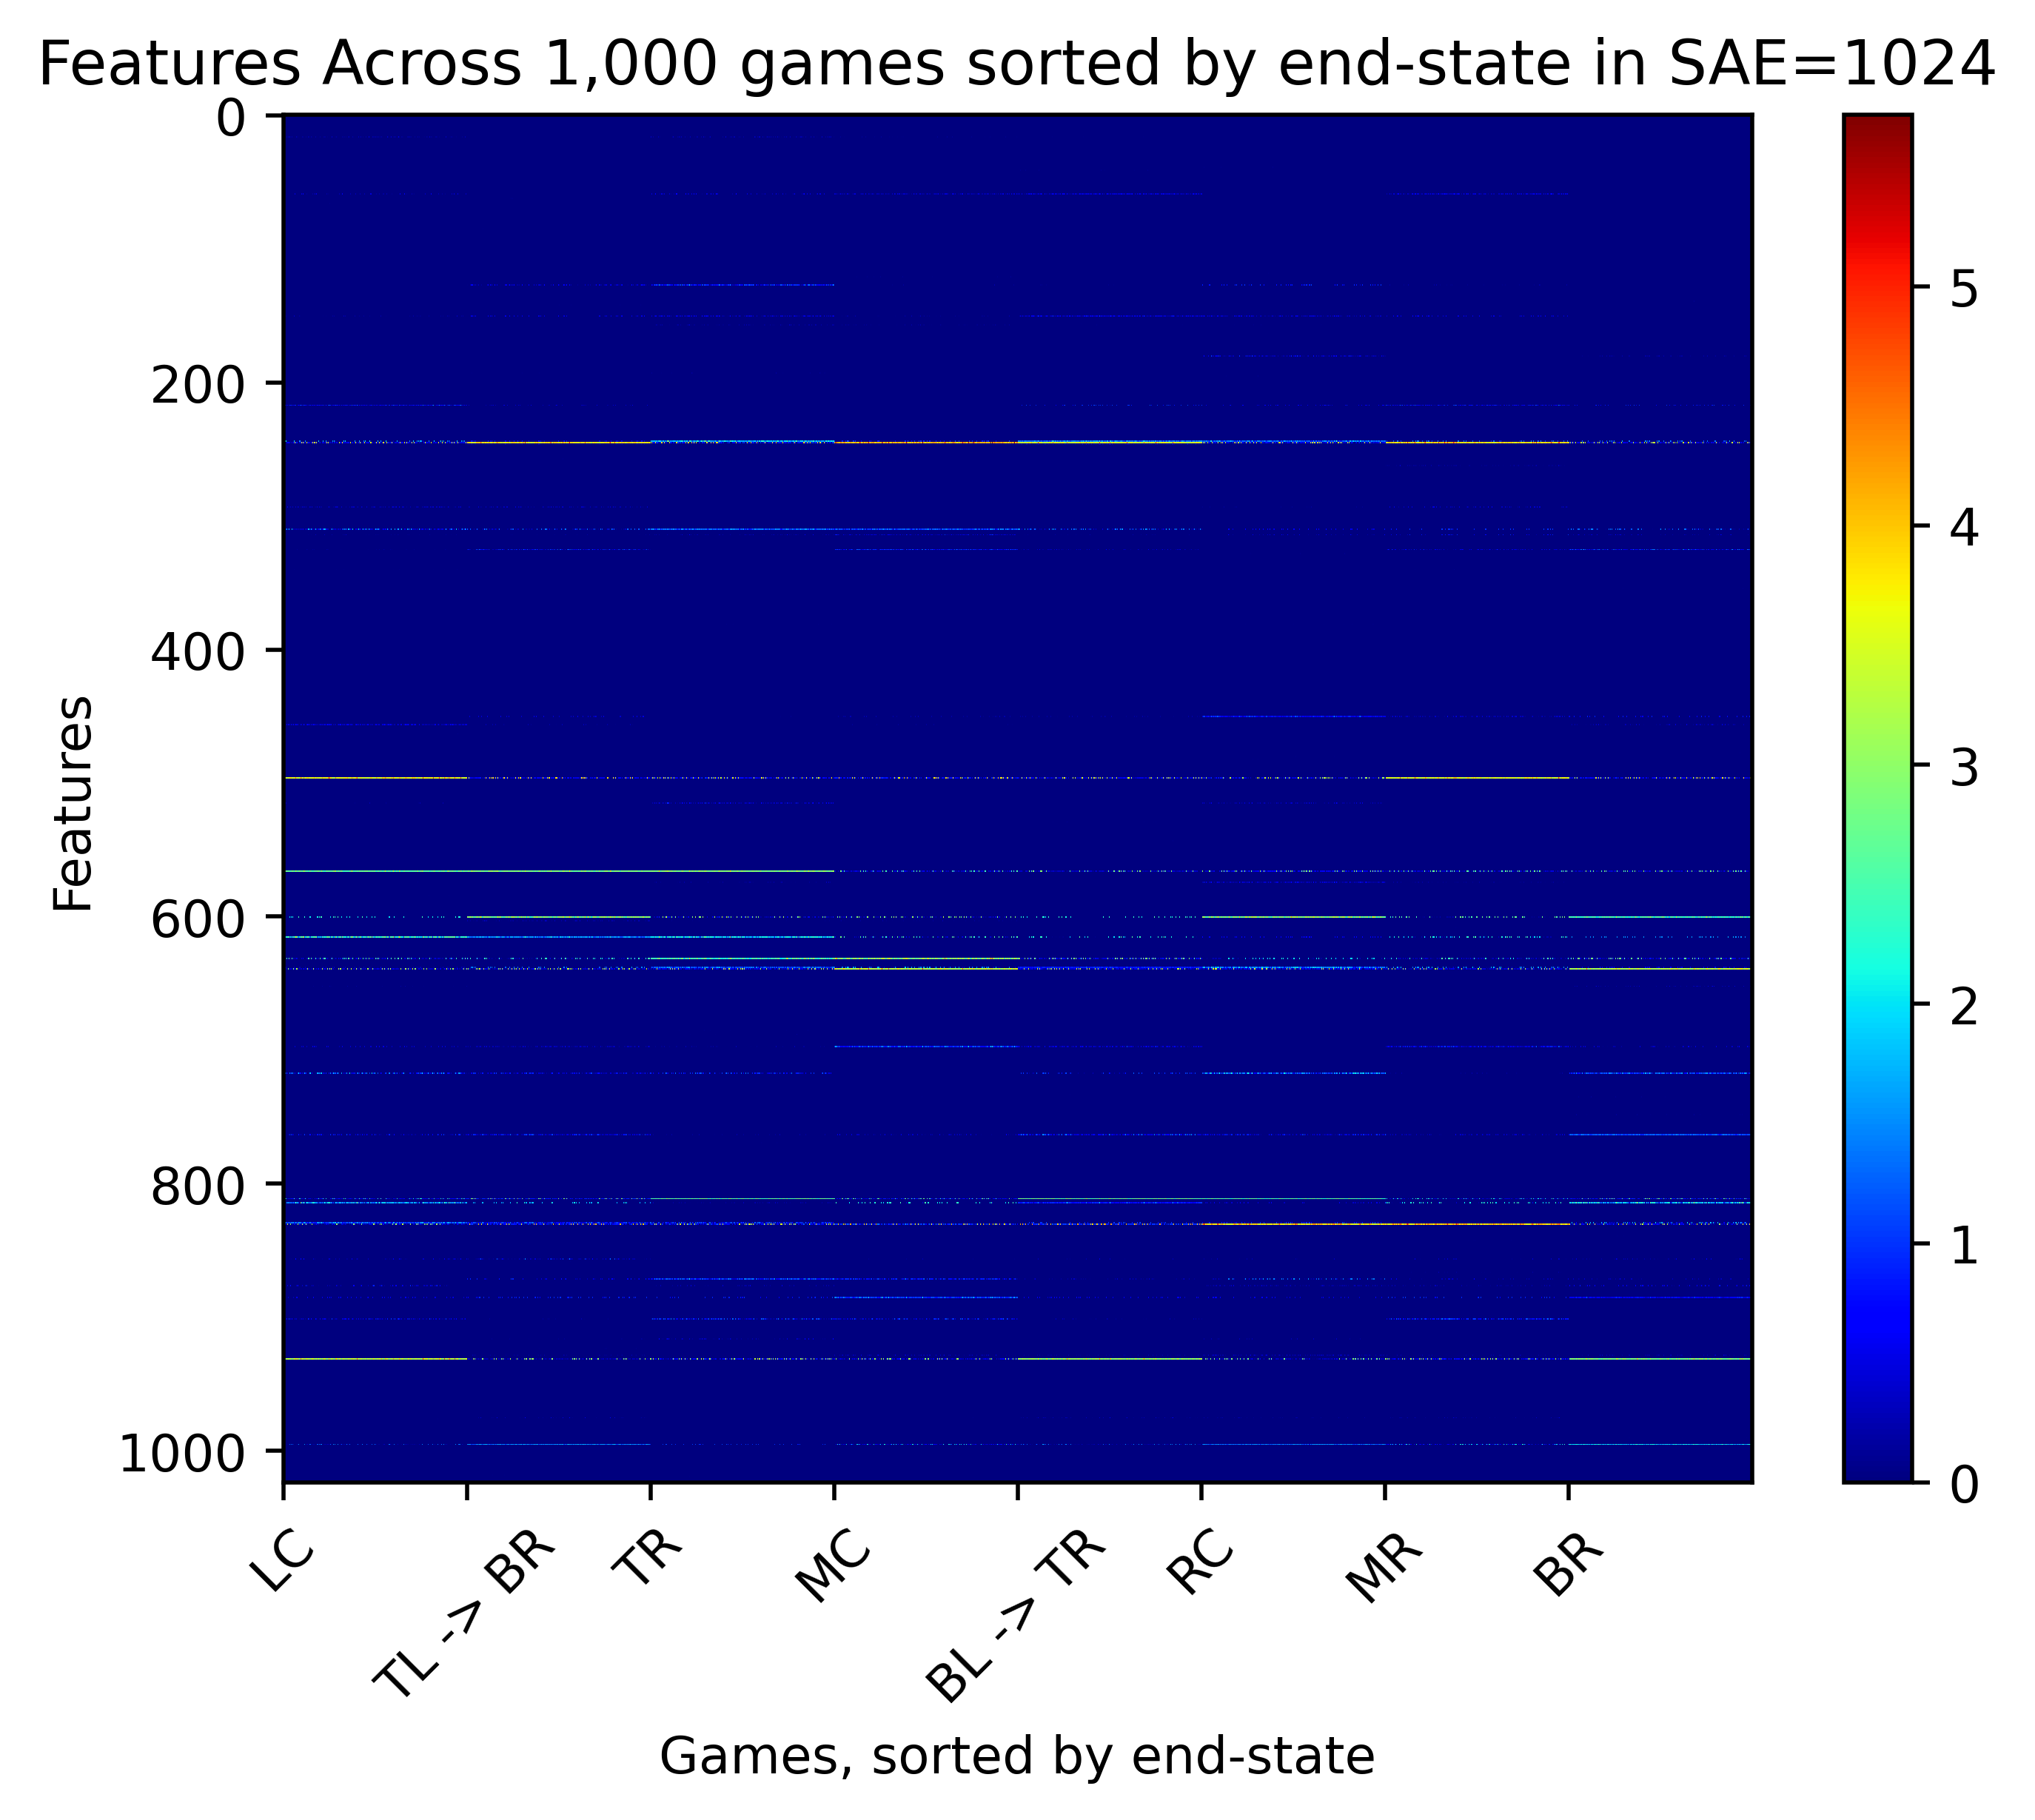

In [22]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_features, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()

plt.xlabel("Games, sorted by end-state")
plt.xticks(
    ticks=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000],
    labels=["LC", "TL -> BR", "TR", "MC", "BL -> TR", "RC", "MR", "BR"],
)
# xtick 45 degree
plt.xticks(rotation=45)
plt.ylabel("Features")
# title
plt.title(
    "Features Across 1,000 games sorted by end-state in SAE=1024",
    fontsize=12,
)
plt.gcf().set_facecolor("white")

In [23]:
# plot.imshow_div(all_features, width=100, height=100)

In [57]:
activation_indices = {
    245: 4,
    496: 3,
    566: 0,
    # 600: 8,
    995: 8,
    631: 1,
    639: 7,
    811: 2,
    830: 5,
    931: 6,
}

win_type_to_moves = {
    "left column": {0, 3, 6},
    "top left -> bottom right": {0, 4, 8},
    "top row": {0, 1, 2},
    "middle column": {1, 4, 7},
    "bottom left -> top right": {6, 4, 2},
    "right column": {2, 5, 8},
    "middle row": {3, 4, 5},
    "bottom row": {6, 7, 8},
}

In [58]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_52900/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [59]:
two_col_games = games[["moves played", "first win condition"]]

In [60]:
non_9_move_games = two_col_games.iloc[:100_000]

In [61]:
len(non_9_move_games)

100000

In [62]:
all_moves = [
    torch.tensor([10] + eval(non_9_move_games["moves played"][i]))
    for i in range(100_000)
]

In [63]:
tt(all_moves)

list (100000)
    └── Tensor (dtype: torch.int64)
        │   (device: cpu)
        └── dim_0 (6)


In [64]:
acts_on_all_games = []
for moves in tqdm.tqdm(all_moves):
    with torch.no_grad():
        acts_on_all_games.append(
            autoenc_cool.get_activations(neuron_activations(moves))
        )
    torch.cuda.empty_cache()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:52<00:00, 1904.38it/s]


In [65]:
all_act_tensor = torch.stack([acts[0, -1] for acts in acts_on_all_games])

In [66]:
tt(all_act_tensor)

Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (100000)
    └── dim_1 (1024)


In [67]:
move_indices = torch.zeros(100_000, 9)

In [68]:
for k, v in activation_indices.items():
    move_indices[:, v] = all_act_tensor[:, k]

In [69]:
tt(move_indices)

Tensor (dtype: torch.float32)
    │   (device: cpu)
    ├── dim_0 (100000)
    └── dim_1 (9)


- All moves playedc
- winner moves played
- moves played by winner

In [70]:
all_moves

[tensor([10,  0,  1,  3,  2,  6]),
 tensor([10,  0,  1,  3,  4,  6]),
 tensor([10,  0,  1,  3,  5,  6]),
 tensor([10,  0,  1,  3,  7,  6]),
 tensor([10,  0,  1,  3,  8,  6]),
 tensor([10,  0,  1,  4,  2,  8]),
 tensor([10,  0,  1,  4,  3,  8]),
 tensor([10,  0,  1,  4,  5,  8]),
 tensor([10,  0,  1,  4,  6,  8]),
 tensor([10,  0,  1,  4,  7,  8]),
 tensor([10,  0,  1,  6,  2,  3]),
 tensor([10,  0,  1,  6,  4,  3]),
 tensor([10,  0,  1,  6,  5,  3]),
 tensor([10,  0,  1,  6,  7,  3]),
 tensor([10,  0,  1,  6,  8,  3]),
 tensor([10,  0,  1,  8,  2,  4]),
 tensor([10,  0,  1,  8,  3,  4]),
 tensor([10,  0,  1,  8,  5,  4]),
 tensor([10,  0,  1,  8,  6,  4]),
 tensor([10,  0,  1,  8,  7,  4]),
 tensor([10,  0,  2,  3,  1,  6]),
 tensor([10,  0,  2,  3,  4,  6]),
 tensor([10,  0,  2,  3,  5,  6]),
 tensor([10,  0,  2,  3,  7,  6]),
 tensor([10,  0,  2,  3,  8,  6]),
 tensor([10,  0,  2,  4,  1,  8]),
 tensor([10,  0,  2,  4,  3,  8]),
 tensor([10,  0,  2,  4,  5,  8]),
 tensor([10,  0,  2,

In [71]:
game = move_indices[0, [i for i in range(9)]] > 0

In [72]:
move_indices

tensor([[3.0301, 0.7292, 0.5861,  ..., 4.6765, 0.0000, 0.0000],
        [2.9253, 0.7264, 0.0000,  ..., 4.5367, 0.0000, 0.0000],
        [2.9829, 0.6150, 0.0000,  ..., 4.6790, 0.0000, 0.0000],
        ...,
        [2.5989, 0.4478, 0.5149,  ..., 3.3647, 0.3051, 0.0000],
        [2.6837, 0.0331, 0.9246,  ..., 3.1144, 0.6348, 1.3971],
        [3.0206, 0.2215, 0.9283,  ..., 3.0251, 3.2368, 1.5317]])

In [73]:
game_cmp = torch.tensor([True if i in all_moves[0][1:] else False for i in range(9)])

In [74]:
torch.equal(game, game_cmp)

True

In [75]:
game_index = 1
game = move_indices[game_index, list(range(9))] > 0
game_cmp = torch.tensor([i in all_moves[game_index][1:] for i in range(9)])
isqual = torch.equal(game, game_cmp)
print(game)
print(game_cmp)
print(isqual)

tensor([ True,  True, False,  True,  True, False,  True, False, False])
tensor([ True,  True, False,  True,  True, False,  True, False, False])
True


In [76]:
is_goods = []
"""
Are the acts above 0?
are the acts above 0 also the ones that correspond to the moves played?
"""
for game_index in range(len(all_moves)):
    game = move_indices[game_index, list(range(9))] > 0
    game_cmp = torch.tensor([i in all_moves[game_index][1:] for i in range(9)])
    is_goods.append(game == game_cmp)
    # is_goods.append(torch.equal(game, game_cmp))
even_better_goods = torch.stack(is_goods)

In [77]:
even_better_goods.sum(0)

tensor([ 99471,  91862,  94026,  99993, 100000,  99004,  99867,  99996,  87870])

In [78]:
100_000 - (-1 * even_better_goods.sum(0) + 100_000).sum()

tensor(72089)

In [79]:
tt(even_better_goods)

Tensor (dtype: torch.bool)
    │   (device: cpu)
    ├── dim_0 (100000)
    └── dim_1 (9)


In [80]:
len(is_goods)

100000

In [81]:
sum(is_goods)

tensor([ 99471,  91862,  94026,  99993, 100000,  99004,  99867,  99996,  87870])

In [82]:
is_off_properly = []
for game_index in range(len(all_moves)):
    game = move_indices[game_index, list(range(9))] > 0
    for move, act in enumerate(game):
        if act == 0:
            pass
        else:
            if move in all_moves[game_index][1:]:
                is_off_properly.append(True)
            else:
                is_off_properly.append(False)
print(len(is_off_properly))
print(sum(is_off_properly))
print(sum(is_off_properly) / len(is_off_properly))

725661
717411
0.9886310549967546


# 99% Monosemantic babyyyyyyy

There's two things we can check:
- Are the features monosemantic (checking the negative case, making sure that feature isn't present when it shouldn't be present)
- Do the features completely cover the features we thought of (is there a 1 to 1 correspondence between the features and moves)

2 current avenues:
- What features do we need to include to get our 64% inference ability up to 99%
- What happens if we ablate the features of the autoencoder, does that actually correspond to how we should predict it will?


In [85]:
autoenc_cool.W_out.shape

torch.Size([1024, 512])

In [91]:
autoenc_cool.W_out[995].T @ autoenc_cool.W_out[600] / (1.2885 * 1.4118)

tensor(0.8250, device='cuda:0', grad_fn=<DivBackward0>)

In [92]:
print(torch.linalg.norm(autoenc_cool.W_out[995]))
print(torch.linalg.norm(autoenc_cool.W_out[600]))

print(autoenc_cool.W_out[995].T @ autoenc_cool.W_out[995])
autoenc_cool.W_out[995].T @ autoenc_cool.W_out[600] / (1.2885 * 1.4118)

tensor(1.2885, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(1.4118, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(1.6602, device='cuda:0', grad_fn=<DotBackward0>)


In [95]:
def cosim(i1, i2):
    v1 = autoenc_cool.W_out[i1]
    v2 = autoenc_cool.W_out[i2]
    return v1.T @ v2 / (torch.linalg.norm(v1) * torch.linalg.norm(v2))

In [96]:
cosim(995, 600)

tensor(0.8250, device='cuda:0', grad_fn=<DivBackward0>)

In [102]:
[cosim(995, i) for i in range(20)]

[tensor(0.0999, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0831, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1708, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0334, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0438, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2056, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(-0.0487, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0537, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(-0.0160, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(-0.0530, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(-0.0253, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0669, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0307, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2365, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1091, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(-0